# **INF161 - Bike Traffic Prediction Project**
### *Ole Kristian Westby | owe009@uib.no | H23*

This project uses data from Statens vegvesen and Geofysisk institutt. The goal is to create a model that can predict the volume of cyclists at a given time over Nygårdsbroen. I'll need to prepare the data so I'm left with the data I deem valuable to perform this task. That's what this Jupyter notebook is for. I'll also be explaining my steps throughout the book. At the end, we'll have some juicy, ready data that we'll use to insert into /ready_data/ ready for the model to work on.

I recognize that throughout the years there has been some times where people might have used the bikes more/less frequently because of certain factors. I will keep a list that I will update continuously as I find them.
- Covid-19 likely kept more people home, especially in peak times. Less people using bicycles to get to work as they had work from home. Only interested in peak covid-19 times though. 
- 2017 UCI Road World Championships. I've checked the routes and don't see that any bikes passed Nygårdsbroen but I will look closer at the data later.
- 

#### **Let's start by importing some libraries.**

In [263]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

#### **We'll handle the traffic data first.**

In [264]:
dir_weather = "raw_data/weather_data/"

# List of all .csv files in /weather_data/
files = [f for f in os.listdir(dir_weather) if f.endswith('.csv')]

# Interesting columns
columns = ["Dato", "Tid", "Globalstraling", "Solskinstid", "Lufttemperatur", "Vindstyrke", "Vindkast"]

# Individual dataframes, initialized as empty list
dfs = []

# For every .csv file, append to dataframe list
for file in files:
    file_path = os.path.join(dir_weather, file)
    df = pd.read_csv(file_path, usecols=columns)
    dfs.append(df)

# Merge all dataframes into one
merged_weather_df = pd.concat(dfs, ignore_index=True)

merged_weather_df.tail()

,Dato,Tid,Globalstraling,Solskinstid,Lufttemperatur,Vindstyrke,Vindkast
709216,2023-06-30,23:10,0.7,0.0,13.7,2.3,3.6
709217,2023-06-30,23:20,0.7,0.0,13.6,1.9,3.3
709218,2023-06-30,23:30,0.8,0.0,13.6,1.7,3.0
709219,2023-06-30,23:40,0.8,0.0,13.6,1.9,3.3
709220,2023-06-30,23:50,0.8,0.0,13.5,1.9,3.0


#### **Now we've created one big dataframe containing all interesting weather data from 2010 to 2023. However, the traffic data only goes from 2015-2023, and so I want to clear the dataset for any weather data before that. The model is going to get slightly less accurate with less data, but I think there's enough data already with 2015-2023 to do this anyways. It makes it simpler as well. I won't remove the data from the raw_data folder because I still recognize it there, and I want to see the different predictions based on it being included or not, but for now I won't focus on it.**

In [265]:
# Convert to pandas datetime format
merged_weather_df["Dato"] = pd.to_datetime(merged_weather_df["Dato"])

# Filter for 2015 and later
merged_weather_df = merged_weather_df[merged_weather_df["Dato"].dt.year >= 2015]

# Reset index for visualization
merged_weather_df = merged_weather_df.reset_index(drop=True)

merged_weather_df.head()
print(merged_weather_df)

             Dato    Tid  Globalstraling  Solskinstid  Lufttemperatur  \
0      2015-01-01  00:00            18.1          0.0             6.6   
1      2015-01-01  00:10            19.5          0.0             6.6   
2      2015-01-01  00:20            20.2          0.0             6.6   
3      2015-01-01  00:30            20.2          0.0             6.6   
4      2015-01-01  00:40            20.2          0.0             6.7   
...           ...    ...             ...          ...             ...   
446749 2023-06-30  23:10             0.7          0.0            13.7   
446750 2023-06-30  23:20             0.7          0.0            13.6   
446751 2023-06-30  23:30             0.8          0.0            13.6   
446752 2023-06-30  23:40             0.8          0.0            13.6   
446753 2023-06-30  23:50             0.8          0.0            13.5   

        Vindstyrke  Vindkast  
0              4.2       NaN  
1              4.0       NaN  
2              3.1       NaN  

#### **As we see in the beginning of the merged dataframe, we see some data missing in 2015-01-01 for Vindkast. I want clean, full data and who knows how many rows are missing data in one or more columns. Let's find out.**

In [266]:
# Counting how many missing-data-rows
rows_missing_data = merged_weather_df[merged_weather_df.isna().any(axis=1)].shape[0]

print(rows_missing_data)

4677


#### **As we can see, there are 4677 rows that are missing some data. 4677 is only ~1% of the merged dataframe. I think we can afford to get rid of that.**

In [267]:
# Replace the missing data rows
merged_weather_df.replace(9999.99, np.nan, inplace=True)

# Converting df to best types
merged_weather_df = merged_weather_df.convert_dtypes()

# Drop missing value rows
merged_weather_df.dropna(inplace=True)

# Visualization
merged_weather_df = merged_weather_df.reset_index(drop=True)

merged_weather_df.tail()

,Dato,Tid,Globalstraling,Solskinstid,Lufttemperatur,Vindstyrke,Vindkast
435290,2023-06-30,23:10,0.7,0.0,13.7,2.3,3.6
435291,2023-06-30,23:20,0.7,0.0,13.6,1.9,3.3
435292,2023-06-30,23:30,0.8,0.0,13.6,1.7,3.0
435293,2023-06-30,23:40,0.8,0.0,13.6,1.9,3.3
435294,2023-06-30,23:50,0.8,0.0,13.5,1.9,3.0


#### **The next thing I want to do is combine the columns "Dato" and "Tid" to get a single datetime column. This will be useful later.**

In [268]:
# Converting both to a string to combine them
merged_weather_df["Dato"] = merged_weather_df["Dato"].astype(str)
merged_weather_df["Tid"] = merged_weather_df["Tid"].astype(str)

# Combining
merged_weather_df["Datotid"] = merged_weather_df["Dato"] + " " + merged_weather_df["Tid"]

# Pandas datetime
merged_weather_df["Datotid"] = pd.to_datetime(merged_weather_df["Datotid"])

# Drop old cols
merged_weather_df.drop(["Dato", "Tid"], axis=1, inplace=True)

print(merged_weather_df)

        Globalstraling  Solskinstid  Lufttemperatur  Vindstyrke  Vindkast  \
0                  7.7          0.0             4.4         1.3       3.6   
1                  7.0          0.0             4.7         1.6       2.7   
2                  6.3          0.0             4.5         1.9       2.7   
3                  5.6          0.0             4.2         3.2       5.4   
4                  8.4          0.0             4.5         2.8       4.5   
...                ...          ...             ...         ...       ...   
435290             0.7          0.0            13.7         2.3       3.6   
435291             0.7          0.0            13.6         1.9       3.3   
435292             0.8          0.0            13.6         1.7       3.0   
435293             0.8          0.0            13.6         1.9       3.3   
435294             0.8          0.0            13.5         1.9       3.0   

                   Datotid  
0      2015-01-08 15:30:00  
1      2015-01-08

#### **The next we'll do is look at the traffic data**

In [269]:
# Initialize traffic data as dataframe
dir_traffic = "raw_data/traffic_data/trafikkdata.csv"
traffic_df = pd.read_csv(dir_traffic, delimiter=";")
traffic_df.tail()

C:\Users\owe05\AppData\Local\Temp\ipykernel_3936\957446941.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  traffic_df = pd.read_csv(dir_traffic, delimiter=";")


,Trafikkregistreringspunkt,Navn,Vegreferanse,Fra,Til,Dato,Fra tidspunkt,Til tidspunkt,Felt,Trafikkmengde,"Dekningsgrad (%)|Antall timer total|Antall timer inkludert|Antall timer ugyldig|Ikke gyldig lengde|Lengdekvalitetsgrad (%)|< 5,6m|>= 5,6m|5,6m - 7,6m|7,6m - 12,5m|12,5m - 16,0m|>= 16,0m|16,0m - 24,0m|>= 24,0m"
348635,17510B2483952,Gamle Nygårdsbru sykkel,KV256 S2D1 m75,2023-07-01T23:00+02:00,2023-07-02T00:00+02:00,2023-07-01,23:00,00:00,1,NaN,|||||||||||||
348636,17510B2483952,Gamle Nygårdsbru sykkel,KV256 S2D1 m75,2023-07-01T23:00+02:00,2023-07-02T00:00+02:00,2023-07-01,23:00,00:00,2,NaN,|||||||||||||
348637,17510B2483952,Gamle Nygårdsbru sykkel,KV256 S2D1 m75,2023-07-01T23:00+02:00,2023-07-02T00:00+02:00,2023-07-01,23:00,00:00,Totalt i retning Danmarksplass,NaN,|||||||||||||
348638,17510B2483952,Gamle Nygårdsbru sykkel,KV256 S2D1 m75,2023-07-01T23:00+02:00,2023-07-02T00:00+02:00,2023-07-01,23:00,00:00,Totalt i retning Florida,NaN,|||||||||||||
348639,17510B2483952,Gamle Nygårdsbru sykkel,KV256 S2D1 m75,2023-07-01T23:00+02:00,2023-07-02T00:00+02:00,2023-07-01,23:00,00:00,Totalt,NaN,|||||||||||||


#### **It's clear there's A LOT of information we don't need/want for the project. I am happy to see the amount of rows aren't that far away from my weather dataframe.**

In [270]:
# Filter dataframe where "Felt" == "Totalt" and keep interesting cols
traffic_df = (
    traffic_df[traffic_df["Felt"] == "Totalt"]
    .loc[:, ["Dato", "Fra tidspunkt", "Trafikkmengde"]]

    # New datetime format and combining cols
    .assign(Datotid=lambda x: pd.to_datetime(x["Dato"] + " " + x["Fra tidspunkt"]))
    
    # Drop old cols
    .drop(columns=["Dato", "Fra tidspunkt"])
)

# Filter for missing data, fix indexing and set index to datetime
traffic_df.dropna(inplace=True)
traffic_df = traffic_df.reset_index(drop=True)
traffic_df.set_index("Datotid", inplace=True)

print(traffic_df)

                    Trafikkmengde
Datotid                          
2015-07-16 15:00:00             -
2015-07-16 16:00:00           101
2015-07-16 17:00:00            79
2015-07-16 18:00:00            56
2015-07-16 19:00:00            45
...                           ...
2022-12-31 19:00:00           0.0
2022-12-31 20:00:00           0.0
2022-12-31 21:00:00           3.0
2022-12-31 22:00:00           5.0
2022-12-31 23:00:00           1.0

[65361 rows x 1 columns]


#### **We now have two dataframes that are sorted for only information I need. However, every row in the weather dataframe is 10 minutes, while the traffic dataframe is an hour. I will have to reduce the amount of rows in weather so it shows hourly instead.**

In [271]:
merged_weather_df.set_index("Datotid", inplace=True)

# Perfect opportunity to rename the variable.
weather_df = merged_weather_df.resample("H").mean()

weather_df.tail(10)

,Globalstraling,Solskinstid,Lufttemperatur,Vindstyrke,Vindkast
Datotid,,,,,
2023-06-30 14:00:00,532.633333,6.0,16.433333,4.316667,6.7
2023-06-30 15:00:00,369.983333,0.766667,16.3,4.25,7.3
2023-06-30 16:00:00,173.916667,0.166667,15.533333,4.2,6.55
2023-06-30 17:00:00,36.65,0.0,13.533333,3.65,6.35
2023-06-30 18:00:00,117.6,2.0,13.583333,2.433333,4.2
2023-06-30 19:00:00,28.88,0.0,13.68,2.86,4.38
2023-06-30 20:00:00,7.966667,0.0,13.283333,2.316667,3.9
2023-06-30 21:00:00,1.816667,0.0,13.466667,3.25,5.2
2023-06-30 22:00:00,0.416667,0.0,13.55,2.65,4.05


#### **Let's merge them together now for the almost-finished product. For fun dataanalysis we need to convert the traffic volume from an object to an int.**

In [272]:
# Join to one dataframe
ready_df = traffic_df.join(weather_df, how="inner")

# Setting traffic volume to an int as it was previously an object
ready_df["Trafikkmengde"] = pd.to_numeric(ready_df["Trafikkmengde"], errors="coerce")
ready_df["Trafikkmengde"].fillna(ready_df["Trafikkmengde"].mean(), inplace=True)
ready_df["Trafikkmengde"] = ready_df["Trafikkmengde"].astype(int)

ready_df.reset_index(inplace=True)

ready_df.tail(10)

,Datotid,Trafikkmengde,Globalstraling,Solskinstid,Lufttemperatur,Vindstyrke,Vindkast
65351,2022-12-31 14:00:00,11,3.333333,0.0,3.566667,2.566667,4.55
65352,2022-12-31 15:00:00,13,-0.1,0.0,3.133333,1.533333,3.2
65353,2022-12-31 16:00:00,6,-0.85,0.0,2.533333,0.85,1.55
65354,2022-12-31 17:00:00,2,-0.2,0.0,1.883333,0.983333,1.75
65355,2022-12-31 18:00:00,8,0.133333,0.0,2.016667,1.4,2.75
65356,2022-12-31 19:00:00,0,-0.4,0.0,1.766667,1.283333,2.45
65357,2022-12-31 20:00:00,0,-0.15,0.0,0.666667,1.7,3.15
65358,2022-12-31 21:00:00,3,-1.75,0.0,0.483333,0.833333,1.6
65359,2022-12-31 22:00:00,5,-0.933333,0.0,0.516667,2.166667,4.2
65360,2022-12-31 23:00:00,1,-3.983333,0.0,0.316667,0.466667,1.1


#### **There's the final product. Ish.. we still need to train the model on this data. I was originally worried we wouldn't have too many rows available but it seems with 65361 rows, I am sure that's enough to get some good predictions!**

#### **Now, while I'm here.. I am curious about a couple things. Like: what's the most popular time/day, what's the best temperature, best windstrength.**

In [273]:
# Best time
best_hour = ready_df.groupby(ready_df["Datotid"].dt.hour)["Trafikkmengde"].mean().idxmax()
print(f"Best time of day is: {best_hour}:00\n----------------------------------------------------")

# Average per day
daily_cyclists_per_day = ready_df.resample("D", on="Datotid")["Trafikkmengde"].sum()
avg_cyclists_per_day = daily_cyclists_per_day.groupby(daily_cyclists_per_day.index.dayofweek).mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_cyclists_per_day.index = avg_cyclists_per_day.index.map(lambda x: days[x])
print(f"The average cyclists per day: \n {avg_cyclists_per_day} \n ----------------------------------------------------")

# Best temperature
best_temp = ready_df.groupby('Lufttemperatur')['Trafikkmengde'].mean().idxmax()
print(f"The temperature with the highest average bicycle traffic is: {round(best_temp,1)}°C")

# Best windstrength
best_wind = ready_df.groupby('Vindstyrke')['Trafikkmengde'].mean().idxmax()
print(f"The wind strength with the highest average bicycle traffic is: {round(best_wind, 2)} m/s")



Best time of day is: 16:00
----------------------------------------------------
The average cyclists per day: 
 Datotid
Monday       1540.933162
Tuesday      1589.442159
Wednesday    1557.789203
Thursday     1459.317949
Friday       1286.800000
Saturday      537.066667
Sunday        485.200514
Name: Trafikkmengde, dtype: float64 
 ----------------------------------------------------
Traffic for March-April each year to visualize Covid-19:
 Datotid
2016    238.075163
2017    158.312329
2018    164.756164
2019    185.210959
2020    143.049180
2021    178.216438
2022    617.741667
Name: Trafikkmengde, dtype: float64 
 ----------------------------------------------------
The temperature with the highest average bicycle traffic is: 26.7°C
The wind strength with the highest average bicycle traffic is: 3.42 m/s


#### **So there you have it.**
- Most popular time is 16:00.
- Most popular day is Tuesday and least popular day is Sunday.
- Covid-19 resulted in the lowest bicycle traffic in March-April compared to other years.
- The best temperature that got the most people out was 26.6°C (this one surprised me).
- The best wind speed was 5.14 m/s.

#### **Let's create the new .csv file for the model**

In [274]:
ready_dir = "ready_data/ready_data.csv"
ready_df.to_csv(ready_dir, index=False)

### **Lastly, some visualizations which will be interesting for the model.**

In [275]:
# Drop rows with NaN values.
clean_ready_df = ready_df.dropna(subset=['Vindstyrke', 'Trafikkmengde'])

### **Wind Speed vs. Traffic**

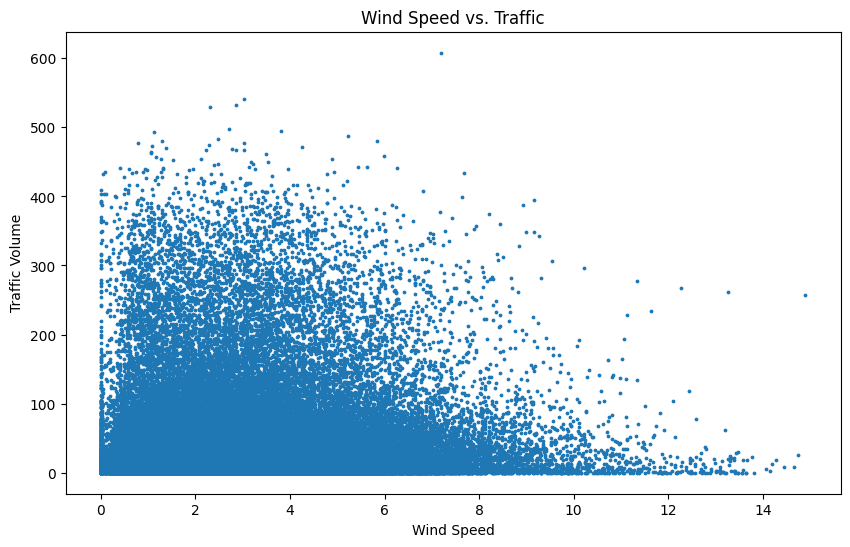

In [276]:
# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter
ax.scatter(clean_ready_df['Vindstyrke'], clean_ready_df['Trafikkmengde'], s=3)

# Title and labels
ax.set_title('Wind Speed vs. Traffic')
ax.set_xlabel('Wind Speed')
ax.set_ylabel('Traffic Volume')

# Show plot
plt.show()

As we can see in the figure above, each point represents a day. It's important to think of the volume of that day as an indicator as to how many people went cycling, and not the amount of points anywhere on the figure. For example, over 14 m/s is a wind speed we rarely get, and hence so little data points. We can count 8 days with more than 14 m/s and 7/8 of those days kept people inside, except one wild day. Majority of people will leave their bike when we get over 8 m/s, which is considered significant.

### **Temperature vs. Traffic**

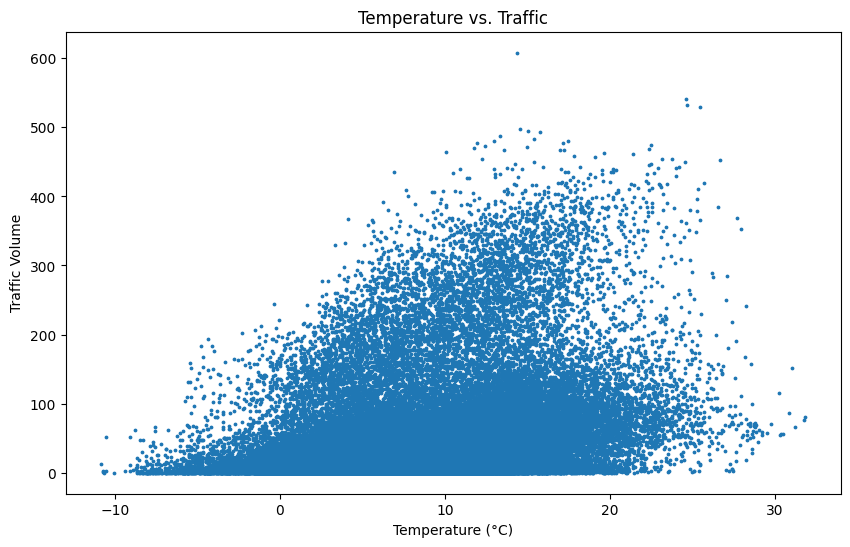

In [277]:
# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter
ax.scatter(clean_ready_df['Lufttemperatur'], clean_ready_df['Trafikkmengde'], s=3)

# Labels
ax.set_title('Temperature vs. Traffic')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Traffic Volume')

# Show
plt.show()

Norway is a pretty cold country, so there's why we see so many data points under 20 celsius. When it's cold, and we're nearing 0 degrees and less, we see a lot less people leaving their bike at home. Specially when we're in -10.  

### **Traffic vs. Weekdays**

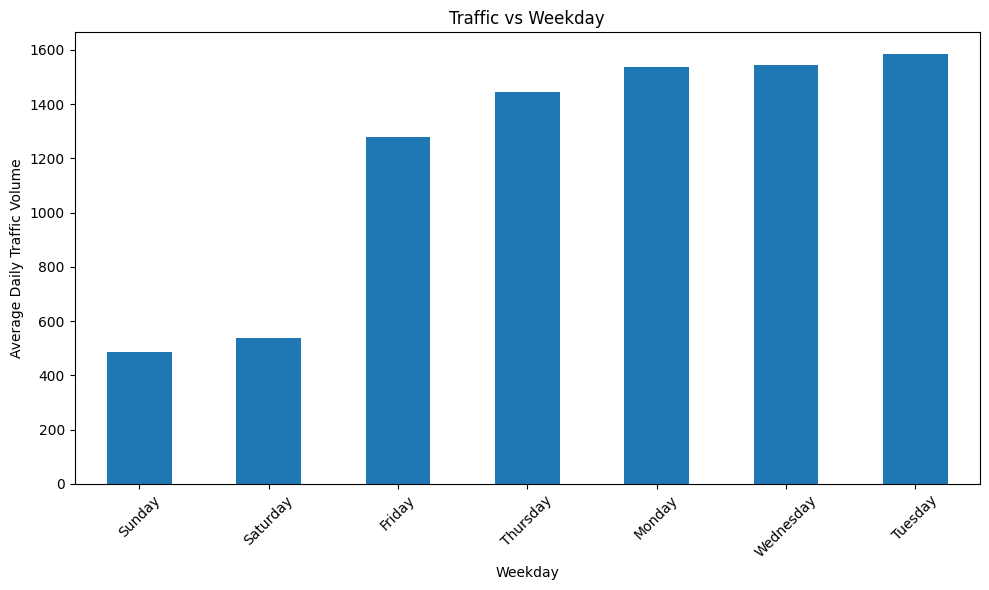

In [278]:
clean_ready_df = clean_ready_df.copy() # Got a warning, decided to go with it.

# Get names from column
clean_ready_df['Weekday'] = clean_ready_df['Datotid'].dt.day_name()

# Get date from column
clean_ready_df['Date'] = clean_ready_df['Datotid'].dt.date

# Calculate daily traffic
daily_traffic = clean_ready_df.groupby(['Date', 'Weekday'])['Trafikkmengde'].sum().reset_index()

# Average daily traffic for each weekday
avg_daily_traffic_per_weekday = daily_traffic.groupby('Weekday')['Trafikkmengde'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).sort_values()

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
avg_daily_traffic_per_weekday.plot(kind='bar', ax=ax)

# Titles, labels
ax.set_title('Traffic vs Weekday')
ax.set_xlabel('Weekday')
ax.set_ylabel('Average Daily Traffic Volume')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Tight plot and show
plt.tight_layout()
plt.show()


Sunday being the least popular day wasn't a big surprise anywhere. 